<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/PetBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 22.3MB/s 
     |████████████████████████████████| 1.1MB 50.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 194kB 52.7MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/Sphynx_144.jpg'),Path('images/saint_bernard_59.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/german_shorthaired_130.jpg'),Path('images/Abyssinian_110.jpg'),Path('images/keeshond_14.jpg'),Path('images/boxer_179.jpg'),Path('images/Bengal_132.jpg'),Path('images/Persian_99.jpg'),Path('images/german_shorthaired_24.jpg')...]

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

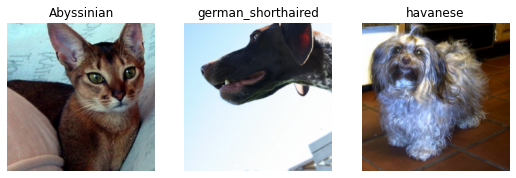

In [8]:
dls.show_batch(nrows=1, ncols=3)

In order to valdiate any mistakes in your `DataBlock` you can run the `summary` method. It will attempt to create a batch from the source you give it (the dataloader below is missing item transforms):

In [9]:
bad_pets_block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
bad_pets_block.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/boxer_124.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/boxer_124.jpg
    applying partial gives
      boxer
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(16)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(16))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: T

RuntimeError: ignored

As soon as your data is looking right, it's good to jump in to a preliminary training of your model to implement a few checks. Below trains our original `DataLoaders` for 2 epochs using the `resnet34` pretrained model (transfer learning again).

In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.500781,0.308122,0.096752,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.517638,0.290257,0.095399,01:13
1,0.341172,0.206173,0.058863,01:14


In the MNIST Loss example, we made use of a simple loss function; its core was mapping a prediction to a sigmoid function to tell if something was more a "3" (1) or a "7" (0). 

When moving away from a binary classification, we need a better way of predicting with multiple categories, and subsequently a better loss function to improve those predictions.

**Cross-Entropy Loss** is:

- Faster and more reliable in training
- Can be used when the dependant variable has more than 2 categories

Let's take a look at the activations of our model. To actually get a batch of real data from our `DataLoaders`, we can use the `one_batch` method:

In [11]:
x,y = dls.one_batch()

When we look at our dependant variable, we see a list of integers; each a number between 0 and 36, representing one of the 37 different pet breeds:

In [12]:
 y

TensorCategory([26, 17, 18, 35, 23, 15, 17, 24, 17,  4, 24, 35, 23, 21,  2, 20, 10, 30,  3,  7, 23, 20, 11, 24, 28, 11, 21,  4,  0, 16,  1,  4, 22, 20, 10,  9, 10, 35, 11,  2, 20, 23, 30,  1,  9, 28,  0, 14,
         7,  1,  5, 34, 24,  6,  8, 12, 21, 14,  3, 11,  6, 35, 15, 20], device='cuda:0')

The predictions from our classification model are 37 different probabilities between 0 and 1, and add up to 1 in total:

In [13]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([7.6538e-05, 9.6691e-07, 5.7106e-08, 4.2468e-06, 3.1152e-07, 8.6200e-09, 4.6993e-09, 1.3482e-08, 2.5587e-08, 7.3295e-06, 2.8758e-05, 7.2019e-04, 4.4839e-07, 8.1026e-05, 9.1037e-07, 1.3788e-06,
        3.7058e-07, 8.9875e-05, 1.1101e-07, 3.2263e-07, 8.3702e-03, 1.4894e-07, 5.2271e-08, 2.7211e-09, 4.3736e-07, 3.1184e-08, 9.9059e-01, 4.1872e-06, 6.4244e-07, 4.7442e-08, 1.6868e-08, 7.7172e-07,
        9.1823e-06, 1.5836e-06, 1.0463e-05, 1.4582e-08, 1.2679e-06])

##Softmax

Transforming our activations from the model into predictions like this is done using **softmax** activation function. Taking a step back to a binary classifier can help in explaining to bridge between our previously used sigmoid function and softmax.

If we have 6 images with 2 possible categories (akin to 3 vs 7 MNIST), and generate a random set of activations (outputs from one layer) like so: 

In [14]:
#hide
torch.random.manual_seed(42);

In [15]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

The sigmoid of this activation directly gives us the relative confidence between 0 and 1 of whether it was one image or the other. But these individual rows wouldn't add up to 1:

In [16]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

We can take the difference between the activations (as that reflects how confident we are of a 3 vs a 7) and take the sigmoid of that relative value:

In [17]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The second column would now  just be that value subtracted from 1. The softmax function performs this same method when there are more than 2 columns, but also incorporates the use of exponent to keep all values positive, and to emphasise difference:

``` python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

In [18]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

An example may be an array of activations for bear types like so: 

```[0.02, -2.49, 1.25]```

The exponent of them would be:

```[1.02, 0.08, 3.49]```

The sum of the exponent would be ```4.60```, so the relative probabilities would be represented as an array like:

```0.22, 0.02, 0.76``` summing to ```1.00```. 

In the binary case above for the first activation set of ```[0.6734, 0.2576]``` it would look like so:

```a = e**0.6734, b = e**0.2576```

With the softmax output being:

```[a/(a+b), b/(a+b)]```

Previously in our binary classifier, we attributed the probablity of it not being what we wanted as the loss. When there are more categories, the loss can be considered the confidence in it not being the target. 

Once we have all our confidence represented via softmax; we can say the loss is our confidence of our target subracted from 1. 

##Negative Log Likelihood
PyTorch provides a function, that when given the activations and the targets of those activations, it will return the respective activations for the targets: 

In [19]:
targ = tensor([0,1,0,1,1,0])

In [20]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

The outputs of this are negative, as the input to `F.nll_loss()` is not meant to be the output of `torch.softmax()` but the output of `torch.log_softmax()`. The reason being, `softmax` whilst this on its own would suffice as a loss function, it's not good at differentiating 0.999 from 0.99 despite there being a 10x confidence difference. Ideally we would stretch this 0->1 to -inf->inf, and can do with log.

Computationally it makes more sense to do the log operation alongside the `softmax` operation, so despite the naming of `F.nll_loss()` the log is taken prior to this function and looks like so:

In [21]:
sm_acts_log = torch.log_softmax(acts, dim=1)
sm_acts_log

tensor([[-5.0672e-01, -9.2248e-01],
        [-6.8903e-01, -6.9729e-01],
        [-2.0160e+00, -1.4293e-01],
        [-3.3658e-03, -5.6958e+00],
        [-5.1760e-01, -9.0621e-01],
        [-1.0048e+00, -4.5589e-01]])

In [22]:
F.nll_loss(sm_acts_log, targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

##Combining the two (Cross-entropy loss):

When we combine the softmax and the negative log likelyhood, the result is called *cross-entropy loss*. As we have seen before, PyTorch combines this functionality and provides it as `nn.CrossEntropyLoss` (does `log_softmax` then `nll_loss`). 

In [23]:
loss_func = nn.CrossEntropyLoss()

In [24]:
loss_func(acts, targ)

tensor(1.8045)

We can also direct it to not reduce the resulting loss tensor into the mean of the values to see the loss for each item:

In [25]:
loss_func = nn.CrossEntropyLoss(reduction="none")

In [26]:
loss_func(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])